# Installs
___

In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 41.8 MB/s eta 0:00:00


In [2]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00


In [4]:
!pip install descriptastorus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00


In [6]:
!pip install molvs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for molvs: filename=MolVS-0.1.1-py3-none-any.whl size=32373 sha256=c6aee071427b175f8eb0c53f4ddca706129b28742a8c0c9fe7e8feedb8b79fc5
  Stored in directory: /root/.cache/pip/wheels/24/a1/39/f02f8173c8ed91bdd386a6c608bb6bf8bd0aba7119315d6f6f
Successfully built molvs


# Imports
___

In [25]:
import scipy
import pandas as pd
import numpy as np
import pytest
import torch
import deepchem as dc
from molvs.tautomer import TautomerCanonicalizer
from deepchem.models import GCNModel
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from descriptastorus.descriptors import rdNormalizedDescriptors
from sklearn.preprocessing import FunctionTransformer
from rdkit.Chem import PandasTools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import matplotlib.pyplot as plt

# GCN Model
___

## Обработка выбросов

Загрузим данные с google drive (пропишите свой путь)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
PATH_small_data = '/content/drive/MyDrive/atomic_hack_dataset_1400.xlsx' #your path here
PATH_big_data = '/content/drive/MyDrive/atomick_hack_dataset_35000.xlsx' #your path here

Берем только колонки SMILES и IC50

In [14]:
data_1 = pd.read_excel(PATH_small_data, usecols=[1, 8])
data_2 = pd.read_excel(PATH_big_data, usecols=[2, 3])

Объединим два датасета и уберем дубликаты

In [15]:
data_1 = data_1.rename(columns={'IC50, mmg/ml': 'IC50'})

In [16]:
data = pd.concat([data_1, data_2])

In [17]:
data = data.drop_duplicates()

In [18]:
data.describe()

,IC50
count,36397.000000
mean,7.752732
std,48.336835
min,0.000010
25%,1.686000
50%,3.632000
75%,5.927000
max,3183.600000


Выбросы удалим, используя межквартильный диапазон

In [19]:
Q1 = data.IC50.quantile(q=.25)
Q3 = data.IC50.quantile(q=.75)
IQR = Q3 - Q1

In [20]:
data_clean = data[~((data.IC50 < (Q1-1.5*IQR)) | (data.IC50 > (Q3+1.5*IQR)))] #убираем данные, который не попадают в межквартильный размах

In [21]:
data_clean.describe()

,IC50
count,34779.000000
mean,3.830751
std,2.689574
min,0.000010
25%,1.582000
50%,3.498000
75%,5.420000
max,12.284000


In [22]:
data_clean.reset_index(inplace=True)

## GCN

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

Реализуем функции для выделения свойств молекул и представления их в виде графа

In [26]:
def get_atom_features(mol):

   atomic_number = []
   num_hs = []
   degrees = []
   charges = []
   tags = []
   hybridizations = []
   aromatic = []
   mass = []

   for atom in mol.GetAtoms():

       atomic_number.append(atom.GetAtomicNum()) # atomic number
       num_hs.append(atom.GetTotalNumHs(includeNeighbors=True)) # number of H in atom
       degrees.append(atom.GetTotalDegree()) # total Degree of atom
       charges.append(atom.GetFormalCharge()) # Charge of atom
       tags.append(int(atom.GetChiralTag())) # chiral tag
       hybridizations.append(int(atom.GetHybridization())) # hybridization of atom

       if atom.GetIsAromatic(): # Is aromatic of not

           aromatic.append(1)

       else:

           aromatic.append(0)

       mass.append(atom.GetMass() * 0.01) # mass

   return torch.tensor([atomic_number, num_hs,
                        degrees, charges,
                        tags, hybridizations,
                        aromatic, mass]).t()


def get_edge_index(mol):

   row, col = [], []

   for bond in mol.GetBonds():

       start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
       row += [start, end]
       col += [end, start]

   return torch.tensor([row, col], dtype=torch.long)

Создание MessagePassing Network\
[Источник](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html)

In [27]:
class GCNConv(MessagePassing):

   def __init__(self, in_channels, out_channels):

       super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
       self.lin = torch.nn.Linear(in_channels, out_channels)

   def forward(self, x, edge_index):

       # x has shape [N, in_channels]
       # edge_index has shape [2, E]

       # Step 1: Add self-loops to the adjacency matrix.
       edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

       # Step 2: Linearly transform node feature matrix.
       x = self.lin(x)

       # Step 3: Compute normalization.
       row, col = edge_index
       deg = degree(col, x.size(0), dtype=x.dtype)
       deg_inv_sqrt = deg.pow(-0.5)
       norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

       # Step 4-5: Start propagating messages.
       return self.propagate(edge_index, x=x, norm=norm)

   def message(self, x_j, norm):

       # x_j has shape [E, out_channels]

       # Step 4: Normalize node features.
       return norm.view(-1, 1) * x_j

Далее реализуем NeuralFP, который будет предоставлять нам обучаемый fingerprint для каждой молекулы

![fp](https://habrastorage.org/r/w1560/getpro/habr/upload_files/8a0/29b/ff1/8a029bff1de9c6280d7b3af3214c95b3.png)

In [28]:
class NeuralFP(nn.Module):

   def __init__(self, atom_features=52, fp_size=50):

       super(NeuralFP, self).__init__()

       self.atom_features = atom_features
       self.fp_size = fp_size


       self.loop1 =  GCNConv(atom_features, fp_size)

       self.loops = nn.ModuleList([self.loop1])

   def forward(self, data):

       x = data[0]
       edge_index = data[1]
       fingerprint = torch.zeros((x.shape[0], self.fp_size), dtype=torch.float).to(device)

       for idx, loop in enumerate(self.loops):

           updated_fingerprint = loop(x, edge_index)
           fingerprint += updated_fingerprint

       return fingerprint

Реализация итоговой нейросети, которая будет подавать полученный фингерпринт на вход полносвязной нейронной сети и получать предсказание



In [44]:
class MLP_Regressor(nn.Module):

   def __init__(self, neural_fp, atom_features=8, fp_size=50, hidden_size=100):
       super(MLP_Regressor, self).__init__()

       self.neural_fp = neural_fp(atom_features=atom_features, fp_size=fp_size)
       self.layers = nn.Sequential(
        nn.Linear(fp_size , hidden_size),
        nn.Dropout(0.2),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size , hidden_size),
        nn.Dropout(0.2),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        )

   def forward(self, batch):

       fp = self.neural_fp(batch)
       out = self.layers(fp)

       return out.mean()

Создадим свой датасет, который будет выдавать матрицу признаков узла, связность графа и таргет

In [31]:
class SMILESMolDataset(Dataset):

    def __init__(self, molecules, y):

        self.molecules = molecules
        self.y = y

    def __len__(self):

        return len(self.molecules)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        mol = self.molecules[idx]

        #The vectorizer was written to work with batches,
        #but PyTorch datasets unfortunately works with single samples

        sample = get_atom_features(mol)
        edge_index = get_edge_index(mol)
        label = self.y[idx]

        return sample, edge_index, label

Добавляем колонку с объектами молекул в формате rdkit

In [30]:
PandasTools.AddMoleculeColumnToFrame(data_clean,'SMILES','Molecule')
data_clean[["SMILES","Molecule"]]

[08:18:09] Conflicting single bond directions around double bond at index 55.
[08:18:09]   BondStereo set to STEREONONE and single bond directions set to NONE.
/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
0,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7c3441817990>
1,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7c3441817a00>
2,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7c3441817a70>
3,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7c3441817ae0>
4,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,<rdkit.Chem.rdchem.Mol object at 0x7c3441817b50>
...,...,...
34774,c1cc(Cl)c(Cl)cc1C(=O)N(CCC2=O)CCN2[C@@H](Cc3cc...,<rdkit.Chem.rdchem.Mol object at 0x7c34415eeff0>
34775,c1cc(O)c(O)cc1\C=C\C(=O)N[C@H](C(=O)O)Cc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7c34415ef060>
34776,O=c1c(O)coc(C)c1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7c34415ef0d0>
34777,c1cccc2[nH]c(c3c12)[C@@H](c4ccccc4)N5[C@@H](C3...,<rdkit.Chem.rdchem.Mol object at 0x7c34415ef140>


Создадим train и test выборки

In [32]:
X = data_clean.Molecule.values
y = data_clean['IC50'].values.reshape(-1, 1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)

In [34]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [37]:
train_dataset = SMILESMolDataset(X_train, y_train)

In [38]:
test_dataset = SMILESMolDataset(X_test, y_test)

Обучение

In [40]:
epochs = 25
hidden_size = 32  # The size of the hidden non-linear layer
fp_size = 50
hidden_size = 45
learning_rate = 0.01  # The initial learning rate for the optimizer

In [45]:
model = MLP_Regressor(neural_fp=NeuralFP, atom_features=8, fp_size=fp_size, hidden_size=hidden_size)
model.to(device)

MLP_Regressor(
  (neural_fp): NeuralFP(
    (loop1): GCNConv()
    (loops): ModuleList(
      (0): GCNConv()
    )
  )
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=45, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=45, out_features=45, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=45, out_features=1, bias=True)
  )
)

In [42]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

In [46]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []

for e in tqdm(range(epochs)):

    running_loss = 0

    for mols, edge_indexes, labels in train_dataset:

        # Push numpy to CUDA tensors
        mols = torch.tensor(mols, device=device).float()
        edge_indexes = torch.tensor(edge_indexes, device=device)
        labels = torch.tensor(labels, device=device).float()

        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model((mols, edge_indexes)) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.detach().item()

    else:


        model.eval()
        with torch.no_grad():

            validation_loss = 0

            for mols, edge_indexes, labels in test_dataset:

                mols = torch.tensor(mols, device=device).float()
                edge_indexes = torch.tensor(edge_indexes, device=device)
                labels = torch.tensor(labels, device=device).float()

                output = model((mols, edge_indexes))
                loss = criterion(output, labels)

                validation_loss += loss / len(test_dataset)


            lr_scheduler.step(validation_loss)

            train_loss = running_loss / len(train_dataset)
            train_losses.append(train_loss)
            validation_losses.append(validation_loss.detach().item())

            if (e+1) % 5 == 0:

                print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))

    torch.cuda.empty_cache()

  0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-46-26c45c32065d>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mols = torch.tensor(mols, device=device).float()
<ipython-input-46-26c45c32065d>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_indexes = torch.tensor(edge_indexes, device=device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/25 [00:35<?, ?it/s]


KeyboardInterrupt: ignored

Визуализация обучения

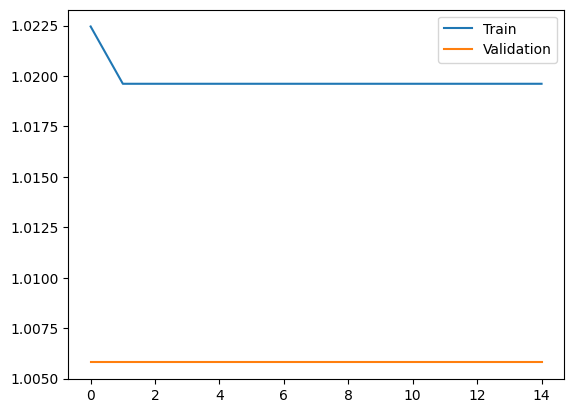

In [98]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.legend()